## <u>Machine Learning Assignmet 2<u>

### Imports and Setup

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, recall_score,
    f1_score, matthews_corrcoef, ConfusionMatrixDisplay, classification_report
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier  # sklearn-compatible

import joblib

sns.set(style="whitegrid")
os.makedirs("model", exist_ok=True)

### Load Dataset

In [2]:
df = pd.read_csv("bank-additional-full.csv", sep=';')

# Target: convert 'yes'/'no' -> 1/0
df['y'] = (df['y'].astype(str).str.strip().str.lower() == 'yes').astype(int)

# Drop 'duration' to avoid target leakage as per UCI
if 'duration' in df.columns:
    df = df.drop(columns=['duration'])

df.shape


(41188, 20)

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


### Exploratory Data Analysis (EDA)

In [4]:
#Dataset Info

print("Dataset Info:\n")
df.info()

Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  euribor3m       

In [5]:
#Display Categorical and Numerical Columns
cat_cols = [c for c in df.columns if df[c].dtype == 'object']
num_cols = [c for c in df.columns if c not in cat_cols + ['y']]
cat_cols, num_cols

(['job',
  'marital',
  'education',
  'default',
  'housing',
  'loan',
  'contact',
  'month',
  'day_of_week',
  'poutcome'],
 ['age',
  'campaign',
  'pdays',
  'previous',
  'emp.var.rate',
  'cons.price.idx',
  'cons.conf.idx',
  'euribor3m',
  'nr.employed'])

In [6]:
#Check for Missing Values
print("Missing values:", df.isna().sum())

Missing values: age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


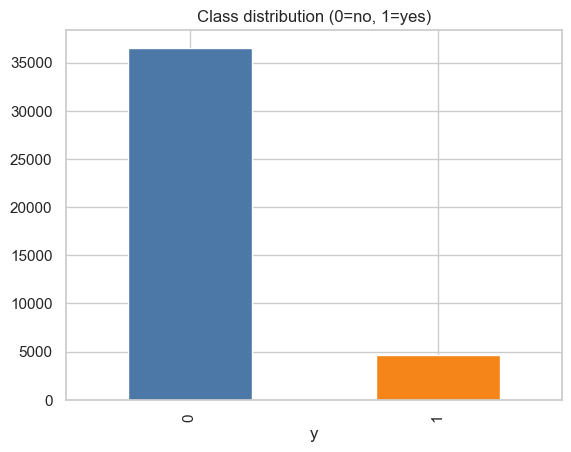

In [7]:
#Class Distribution Plot
ax = df['y'].value_counts().plot(kind='bar', color=['#4c78a8', '#f58518'])
ax.set_title("Class distribution (0=no, 1=yes)")
plt.show()

### Split Dataset into Train-Test

In [8]:

train_df, test_df = train_test_split(
    df, test_size=0.20, random_state=42, stratify=df['y']
)

# Save the test split for GitHub/Streamlit
test_df.to_csv("test_data.csv", index=False)

X_train = train_df.drop(columns=['y'])
y_train = train_df['y'].values
X_test  = test_df.drop(columns=['y'])
y_test  = test_df['y'].values
len(X_train), len(X_test)


(32950, 8238)

In [9]:
df['y'].value_counts(normalize=True)

y
0    0.887346
1    0.112654
Name: proportion, dtype: float64

In [10]:
#Check if class distribution of Terget Y is preserved after split
train_df['y'].value_counts(normalize=True)

y
0    0.887344
1    0.112656
Name: proportion, dtype: float64

In [11]:
#Check if class distribution of Terget Y is preserved after split
test_df['y'].value_counts(normalize=True)

y
0    0.887351
1    0.112649
Name: proportion, dtype: float64

### Pre-Processing

#### Normalization & One-Hot Encoding

In [12]:
# Pipeline for numeric features:
numeric_transformer = Pipeline([('scaler', StandardScaler())])

# Transformer for categorical features:
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Combine separate numeric + categorical transformations with ColumnTransformer :
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='drop'
)

### Define Models

In [13]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=200, class_weight='balanced'),
    'Decision Tree':       DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'kNN':                 KNeighborsClassifier(n_neighbors=15, weights='distance'),
    'Naive Bayes (Gaussian)': GaussianNB(),
    'Random Forest (Ensemble)': RandomForestClassifier(
        n_estimators=300, class_weight='balanced_subsample', random_state=42, n_jobs=-1
    ),
    'XGBoost (Ensemble)': XGBClassifier(
        n_estimators=500, learning_rate=0.05, max_depth=5,
        subsample=0.8, colsample_bytree=0.8,
        random_state=42, objective='binary:logistic', eval_metric='auc',
        tree_method='hist', n_jobs=-1,
        scale_pos_weight=(y_train.tolist().count(0) / y_train.tolist().count(1))
    )
}

### Define Evaluation & Save Function

In [14]:
def evaluate_and_save(name, pipe, X_test, y_test):
    # Generate class predictions (0/1)
    y_pred = pipe.predict(X_test)

    # Generate predicted probabilities (only if the model supports it)
    # Many classifiers (LogisticRegression, RandomForest, XGBoost) have predict_proba()
    y_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe, "predict_proba") else None

    # Compute evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    mcc = matthews_corrcoef(y_test, y_pred)

    # AUC requires probability scores, not class labels
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    # Save the entire trained pipeline (preprocessor + model) to a .pkl file
    joblib.dump(pipe, f"model/{name.replace(' ', '_')}.pkl")

    # Return evaluation results as a dictionary
    return {
        "ML Model Name": name,
        "Accuracy": acc,
        "AUC": auc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "MCC": mcc
    }

### Train, Evaluate Metrics and Save

In [15]:

# List to collect evaluation results from all models
results = []

# Loop through your dictionary of ML models (models = {...})
for name, clf in models.items():
    # Build pipeline for each model: preprocessing + classifier
    pipe = Pipeline([
        ('prep', preprocessor),  # ColumnTransformer
        ('clf', clf)             # ML model
    ])

    # Train model (preprocessing happens automatically inside the pipeline)
    pipe.fit(X_train, y_train)

    # Evaluate model and save it
    results.append(evaluate_and_save(name, pipe, X_test, y_test))

    print("Done:", name)


# Convert list of results into a DataFrame
df_results = pd.DataFrame(results).sort_values("AUC", ascending=False)

# Save model comparison table
df_results.to_csv("model/model_comparison.csv", index=False)

# Display comparison table
df_results

Done: Logistic Regression
Done: Decision Tree
Done: kNN
Done: Naive Bayes (Gaussian)
Done: Random Forest (Ensemble)
Done: XGBoost (Ensemble)


,ML Model Name,Accuracy,AUC,Precision,Recall,F1,MCC
5,XGBoost (Ensemble),0.847172,0.808920,0.391759,0.645474,0.487586,0.421444
0,Logistic Regression,0.835033,0.800941,0.367872,0.646552,0.468933,0.401084
4,Random Forest (Ensemble),0.894999,0.784402,0.567742,0.284483,0.379038,0.352064
3,Naive Bayes (Gaussian),0.804928,0.775499,0.317178,0.634698,0.422980,0.348985
2,kNN,0.895120,0.755854,0.573059,0.270474,0.367496,0.345084
1,Decision Tree,0.846807,0.619170,0.321581,0.324353,0.322961,0.236599


In [16]:
# Pick the best model name
best_name = df_results.iloc[0]["ML Model Name"]

# Load the saved pipeline (preprocessor + classifier) for the best model
best_pipe = joblib.load(f"model/{best_name.replace(' ', '_')}.pkl")

# Generate class predictions (0/1) on the held-out test set
y_pred_best = best_pipe.predict(X_test)

# Report best model and print a detailed classification report
print("Best model:", best_name)
print(classification_report(y_test, y_pred_best, digits=4))

Best model: XGBoost (Ensemble)
              precision    recall  f1-score   support

           0     0.9510    0.8728    0.9102      7310
           1     0.3918    0.6455    0.4876       928

    accuracy                         0.8472      8238
   macro avg     0.6714    0.7591    0.6989      8238
weighted avg     0.8880    0.8472    0.8626      8238



#### Confusion Matrix 

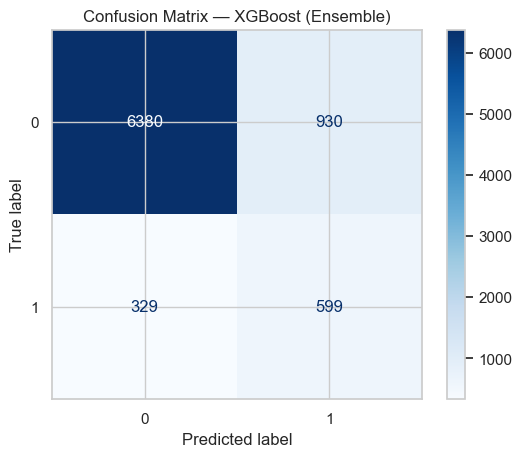

In [17]:
# Plot the confusion matrix for the best model
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best, cmap='Blues')
plt.title(f"Confusion Matrix — {best_name}")
plt.show()